In [63]:
import pandas as pd
import seaborn as sns

In [64]:
df = pd.read_csv('data/BeerDataScienceProject.csv', engine='python')
df.shape

(528870, 13)

In [65]:
df.head(2)

,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time
0,5.0,47986,10325,Sausa Weizen,Hefeweizen,2.5,2.0,1.5,1.5,stcules,1.5,A lot of foam. But a lot. In the smell some ba...,1234817823
1,6.2,48213,10325,Red Moon,English Strong Ale,3.0,2.5,3.0,3.0,stcules,3.0,"Dark red color, light beige foam, average. In ...",1235915097


In [66]:
df.count()

beer_ABV              508590
beer_beerId           528870
beer_brewerId         528870
beer_name             528870
beer_style            528870
review_appearance     528870
review_palette        528870
review_overall        528870
review_taste          528870
review_profileName    528755
review_aroma          528870
review_text           528751
review_time           528870
dtype: int64

<AxesSubplot:>

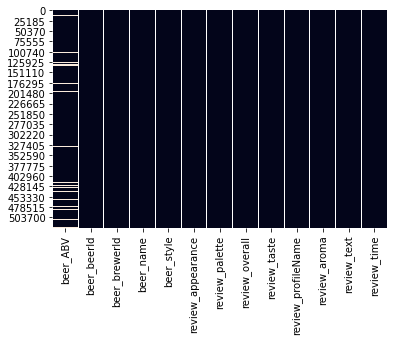

In [67]:
sns.heatmap(df.isnull(), cbar=False)

**beer_ABV** has some missing values.

In [68]:
# Drop missing value rows.
df.dropna(inplace=True, axis=0)

In [69]:
df = df[['beer_beerId', 'review_profileName', 'review_overall']]
df.head()

,beer_beerId,review_profileName,review_overall
0,47986,stcules,1.5
1,48213,stcules,3.0
2,48215,stcules,3.0
3,47969,stcules,3.0
4,64883,johnmichaelsen,4.0


In [71]:
rv_over_all_value_counts = df['review_overall'].value_counts(normalize=True) * 100
rv_over_all_value_counts

4.0    37.301075
4.5    21.197266
3.5    18.584934
3.0     9.999056
5.0     5.956236
2.5     3.426916
2.0     2.196877
1.5     0.729604
1.0     0.607446
0.0     0.000590
Name: review_overall, dtype: float64

<AxesSubplot:ylabel='review_overall'>

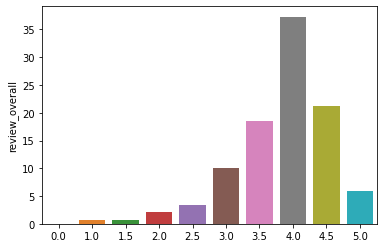

In [72]:
sns.barplot(x=rv_over_all_value_counts.index, y=rv_over_all_value_counts)

We can see that over 37% of all ratings in the data are 4.0, and 21% are in 4.5, 18% are in 3.5 and 
very few ratings are 3.0, 5.0, etc in low ratings.

Drop null rows and remove duplicates rows as well.

In [73]:
df.loc[df['review_profileName'].isnull()].count()

beer_beerId           0
review_profileName    0
review_overall        0
dtype: int64

In [74]:
df.drop_duplicates(keep = 'first', inplace = True)

Distribution of beer_beerId by their counts
- Keep only those beers whose percentile threshold is greater than 90%

In [75]:
# x = df['beer_beerId'].value_counts(ascending=False)
# sns.barplot(x=x.index, y=x)

In [76]:
# Most reviewed beers IDs
df_beer_counts = df['beer_beerId'].value_counts()
perc_beer_90 = df_beer_counts.quantile(0.90)
print('Percentile threshold value: ', perc_beer_90)
most_reviewed_beer_ids = df_beer_counts[df_beer_counts >= perc_beer_90].index.tolist()
most_reviewed_beer_ids
df1 = df[df['beer_beerId'].isin(most_reviewed_beer_ids)]
df1.shape

Percentile threshold value:  50.0


(424068, 3)

Distribution of profile name by their counts
- Keep only those profiles whose percentile threshold value is greater than 90%

In [77]:
# Most reviewed given by user_ids 
df_user_counts = df['review_profileName'].value_counts()
perc_user_90 = df_user_counts.quantile(0.90)
print('Percentile threshold value: ', perc_user_90)
most_reviewed_user_ids = df_user_counts[df_user_counts >= perc_user_90].index.tolist()
most_reviewed_user_ids
df2 = df[df['review_profileName'].isin(most_reviewed_user_ids)]
df2.shape

Percentile threshold value:  53.0


(368483, 3)

Merge both the beer_ids and user_ids dataframes

In [78]:
new_df = df1.merge(df2)
new_df

,beer_beerId,review_profileName,review_overall
0,25414,NJpadreFan,4.0
1,25414,vacax,2.5
2,25414,mdagnew,4.5
3,25414,mikesgroove,4.0
4,25414,hdofu,4.0
...,...,...,...
301770,2176,junjun,4.5
301771,2176,AKBelgianBeast,4.0
301772,2176,kimcgolf,3.0
301773,2176,bennetj17,3.5


In [79]:
new_df.groupby('beer_beerId').review_overall.mean()

beer_beerId
5        3.539735
6        3.693548
7        3.222611
8        3.520000
9        3.382979
           ...   
74591    3.453125
74634    3.894737
74783    3.284314
74827    3.897436
76816    4.060606
Name: review_overall, Length: 1504, dtype: float64

In [80]:
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split

In [81]:
reader = Reader(rating_scale=(0, 4))
data = Dataset.load_from_df(new_df[['beer_beerId', 'review_profileName', 'review_overall']], reader)
data

In [82]:
# benchmark = []

# # Iterate over all algorithms
# for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
#     # Perform cross validation
#     results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
#     # Get results & append algorithm name
#     tmp = pd.DataFrame.from_dict(results).mean(axis=0)
#     tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
#     benchmark.append(tmp)

In [83]:
# surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
# surprise_results

In [84]:
bsl_options = {'method': 'als',
               'n_epochs': 10,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'test_rmse': array([0.58253127, 0.5811437 , 0.57997332]),
 'fit_time': (1.2313051223754883, 1.106044054031372, 1.0454168319702148),
 'test_time': (1.5728638172149658, 0.9680447578430176, 1.4662127494812012)}

In [85]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 0.5773


0.5772811208723996

In [86]:
testset

[(1622, 'ommegangpbr', 3.5),
 (1791, 'NEhophead', 4.5),
 (2779, 'Andreji', 3.5),
 (572, 'ADR', 4.0),
 (18052, 'TastyTaste', 2.0),
 (2899, 'Bighuge', 5.0),
 (25259, 'Squelch', 4.5),
 (1798, 'hiikeeba', 3.0),
 (54522, 'Thorpe429', 4.5),
 (51268, 'ChainGangGuy', 2.0),
 (41421, 'ThirstyHopHead', 4.0),
 (20931, 'sisuspeed', 3.0),
 (56738, 'pweis909', 4.5),
 (18949, 'shbobdb', 4.5),
 (20539, 'number1bum', 4.0),
 (10482, 'rpstevens', 4.5),
 (3970, 'Jason', 4.0),
 (29675, 'scruffwhor', 3.0),
 (36179, 'pinotboy007', 4.0),
 (104, 'Jon', 4.0),
 (429, 'WVbeergeek', 4.5),
 (1912, 'far333', 2.5),
 (2565, 'RoamingGnome', 4.0),
 (6366, 'dfried', 4.5),
 (4904, 'timtheenchanta', 4.5),
 (51483, 'match1112', 4.0),
 (1577, 'beerluvr', 5.0),
 (21100, 'RblWthACoz', 4.0),
 (356, 'nickfl', 4.0),
 (1504, 'udubdawg', 4.0),
 (43431, 'erosier', 4.0),
 (20564, 'mntlover', 4.0),
 (46365, 'wagenvolks', 4.0),
 (283, 'BeanBone', 3.5),
 (16638, 'kmpitz2', 3.0),
 (276, 'kingcrowing', 4.5),
 (40492, 'Tilley4', 4.0),
 (120

In [87]:
predictions = algo.test(testset)

In [88]:
from collections import defaultdict
 
def get_top3_recommendations(predictions, topN = 3):
     
    top_recs = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_recs[uid].append((iid, est))
     
    for uid, user_ratings in top_recs.items():
        user_ratings.sort(key = lambda x: x[1], reverse = True)
        top_recs[uid] = user_ratings[:topN]
     
    return top_recs

In [89]:
res = get_top3_recommendations(predictions)
from pprint import pprint
pprint(dict(res))

{5: [('EnojysAnyBeer', 4),
     ('unclejimbay', 3.8392363641430816),
     ('Luigi', 3.8383911851350305)],
 6: [('NeroFiddled', 4), ('Phatz', 4), ('Murph', 4)],
 7: [('EnojysAnyBeer', 3.7941111597063952),
     ('RonaldTheriot', 3.6994209205020745),
     ('neenerzig', 3.5893221763987877)],
 8: [('Gagnonsux', 3.796251634286291),
     ('CityBoy1986', 3.75737329877357),
     ('JackTheRipper', 3.7544319668795456)],
 9: [('shapudding', 3.5593627904628593),
     ('GeoffRizzo', 3.5512974099452403),
     ('Buggies', 3.4775989922889137)],
 11: [('mzwolinski', 3.8610977539789224),
      ('RBorsato', 3.7323373150691848),
      ('tgbljb', 3.6976998590633983)],
 12: [('OStrungT', 3.8771541762821844),
      ('merlin48', 3.838911202593151),
      ('shippos', 3.8328266975847267)],
 13: [('the42ndtourist', 3.554591643858995),
      ('ppoitras', 3.430813634082569),
      ('putnam', 3.415443723728638)],
 30: [('Bowdoinbeerboy', 4), ('DaftCaskBC', 4), ('Slatetank', 4)],
 31: [('aubuc1', 4), ('CrazyMike', 4)

 1633: [('WesWes', 3.2258595167552966),
        ('BeerCon5', 3.1050829127630495),
        ('WVbeergeek', 3.0701972666951)],
 1635: [('josefnewsong', 3.9251760296030467),
        ('webmanspidey', 3.923873647458498),
        ('sulldaddy', 3.909738266057758)],
 1636: [('RonfromJersey', 4), ('Murph', 4), ('sponberg', 4)],
 1637: [('WesWes', 3.722877350063272),
        ('francisweizen', 3.6905204864724848),
        ('TheLongBeachBum', 3.6303511729684743)],
 1639: [('sulldaddy', 4), ('RonfromJersey', 4), ('tgbljb', 4)],
 1645: [('NeroFiddled', 4),
        ('scootny', 3.8397654376469976),
        ('cvstrickland', 3.8124548924834802)],
 1649: [('Loki', 3.979223976349916),
        ('GeoffFromSJ', 3.9681962854949258),
        ('tgbljb', 3.9599155227473415)],
 1654: [('bjohnson', 4), ('CAMRAhardliner', 4), ('SebD', 4)],
 1655: [('ferrari29', 4), ('marlinsfan4', 4), ('aubuc1', 4)],
 1657: [('donniecuffs', 4), ('RedDiamond', 4), ('pwent', 4)],
 1658: [('IntriqKen', 4), ('Suds', 4), ('tgbljb', 4)],


 5047: [('funkengruven', 3.7062233781934326),
        ('Jarod', 3.7026369444187357),
        ('ecoastman', 3.625034071176371)],
 5070: [('tavernjef', 3.8479660738438857),
        ('dfillius', 3.6420593266735044),
        ('TastyTaste', 3.6397521139865883)],
 5087: [('Dmann', 3.9161034472979317),
        ('Offa', 3.785777258042373),
        ('Domingo', 3.5538686693956767)],
 5096: [('sleazo', 4), ('cabsandking', 4), ('LyonsHead', 4)],
 5110: [('canucklehead', 4),
        ('NeroFiddled', 4),
        ('ludachris', 3.9576584176820817)],
 5132: [('Frosty80', 3.918718185798957),
        ('beernut7', 3.827036160071184),
        ('Kurland', 3.7887743720735054)],
 5133: [('beernut7', 4), ('beergeek279', 4), ('scruffwhor', 4)],
 5170: [('Morris729', 4), ('NeroFiddled', 4), ('SheepNutz', 4)],
 5253: [('JamnesCameron', 3.603159794485087),
        ('Cwrw', 3.5942932370690155),
        ('DrJay', 3.5675494444104925)],
 5281: [('SpeedwayJim', 4), ('oline73', 4), ('koopa', 4)],
 5336: [('Yeastcakes', 3

 13812: [('scottum', 3.769421613047297),
         ('WesWes', 3.769049451369459),
         ('lackenhauser', 3.7128337772773)],
 13825: [('Casey10', 4), ('peabody', 4), ('Georgiabeer', 4)],
 13826: [('jdklks', 4), ('Thorpe429', 4), ('eric5bellies', 4)],
 13850: [('mynie', 3.8352495995602194),
         ('Vancer', 3.609693939813138),
         ('emerge077', 3.6041424185522843)],
 13896: [('cameraman', 4), ('WoodBrew', 4), ('morbiddrumer', 4)],
 14033: [('Lemke10', 3.2611688885674432),
         ('jasonjlewis', 3.142486132131482),
         ('DrJay', 3.091182107973456)],
 14072: [('kbub6f', 3.8952655919474197),
         ('ssbeer', 3.8911665188502678),
         ('bditty187', 3.8600197861835497)],
 14074: [('scruffwhor', 4), ('glid02', 4), ('rajendra82', 4)],
 14218: [('Mebuzzard', 4), ('TheManiacalOne', 4), ('Rayek', 4)],
 14309: [('neenerzig', 3.9898688658922503),
         ('MattyG85', 3.981141764410559),
         ('mynie', 3.9808644294548086)],
 14368: [('oelergud', 4), ('InebriatedJoker', 4)

 28494: [('Parrotbeak', 4),
         ('tmoneyba', 3.9583755332221413),
         ('GbVDave', 3.9582090501618956)],
 28565: [('fank2788', 4), ('GbVDave', 4), ('Franchise', 4)],
 28577: [('ZAP', 4), ('adam42381', 4), ('Mora2000', 4)],
 28578: [('Gavage', 4), ('bluejacket74', 4), ('Risser09', 4)],
 28951: [('rabsten', 3.8997561134324794),
         ('Metalmonk', 3.8567899852354386),
         ('edchicma', 3.811492670776664)],
 28985: [('kirok1999', 3.7104987936727802),
         ('goschool', 3.5996145175881775),
         ('Viggo', 3.5979136419586335)],
 29016: [('czfreeman', 4), ('techdiver', 4), ('JayQue', 3.94983865418505)],
 29077: [('sitarist', 4),
         ('brewandbbq', 3.9053825635119557),
         ('Daniellobo', 3.89965399430669)],
 29125: [('TheLongBeachBum', 4), ('GJ40', 4), ('Sunnanek', 4)],
 29145: [('rtepiak', 4), ('ncvbc', 4), ('Brad007', 4)],
 29204: [('ndekke39', 3.2995416773816353),
         ('shroompod', 3.169573623109957),
         ('secondtooth', 3.1544775917382863)],
 292

         ('cvstrickland', 3.8333890525484176),
         ('LacquerHead', 3.823633028739717)],
 41268: [('Arenbeer', 4), ('mikesgroove', 4), ('bonkers', 4)],
 41345: [('russpowell', 3.9752831644030016),
         ('glid02', 3.9274318904651624),
         ('tmoneyba', 3.9234965711582435)],
 41421: [('irishkyle21', 4), ('tonistruth', 4), ('mikesgroove', 4)],
 41422: [('russpowell', 3.9383092496531047),
         ('aerozeppl', 3.9234408073359965),
         ('WesWes', 3.880724085740966)],
 41427: [('RblWthACoz', 3.9981993729170466),
         ('OStrungT', 3.996909430841272),
         ('erosier', 3.9946243174753877)],
 41453: [('feloniousmonk', 4), ('mikesgroove', 4), ('Sunnanek', 4)],
 41524: [('mynie', 4), ('natasharai', 4), ('Slatetank', 3.8941376998554205)],
 41609: [('gford217', 4), ('cvstrickland', 4), ('corby112', 4)],
 41626: [('gtermi', 4), ('grittybrews', 4), ('oberon', 4)],
 41689: [('mempath', 4),
         ('tavernjef', 3.8677459944026147),
         ('russpowell', 3.780683947260192)],

         ('Cyberkedi', 3.926057658823991),
         ('atsprings', 3.9030218033133677)],
 60940: [('MlhopeTC', 4), ('babaracas', 4), ('smakawhat', 4)],
 61216: [('NeroFiddled', 3.912320465562224),
         ('russpowell', 3.6949154958363373),
         ('scruffwhor', 3.689991159900558)],
 61273: [('mikesgroove', 3.7826717596390234),
         ('indiapaleale', 3.5800930865932923),
         ('Jayli', 3.4812905934484255)],
 61593: [('TheHoppiest', 4), ('wvsabbath', 4), ('billab914', 4)],
 61613: [('nataku00', 3.059984675270689),
         ('Drew966', 3.0505280248729383),
         ('BrewCrew2010', 2.9635076456893645)],
 61753: [('Wasatch', 4), ('sitarist', 4), ('hwwty4', 3.8993762107651677)],
 61877: [('aepb1', 4), ('mikesgroove', 4), ('AgingWarrior', 4)],
 62022: [('russpowell', 3.7915422123679665),
         ('Lemke10', 3.7758903964114654),
         ('Metalmonk', 3.7384958089576217)],
 62063: [('gregshead', 4), ('Halcyondays', 4), ('Mora2000', 4)],
 62206: [('CampusCrew', 3.9384172309355003),


Here, 

### Recommending top 3 beers to users.

For User ID = **5**, it recommends beer **EnojysAnyBeer**, **unclejimbay**, **Luigi**

For User ID = **6**, it recommends beer **NeroFiddled**, **Phatz**, **Murph** 

For User ID = **7**, it recommends beer **EnojysAnyBeer**, **RonaldTheriot**, **neenerzig**

and so on.